<a href="https://colab.research.google.com/github/HoussemDs/Brain-Segmentation-3D-Monai/blob/main/Segmentation_Brain_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain tumor 3D segmentation with Monai
this notebook will recreate the The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)

comming form Ieee papper

this is the like for there paper:https://ieeexplore.ieee.org/document/6975210

in this notebook will will tackle a lot of things from them we have
1. Transforms for dictionary format data
2. Define a new transformation using Monai
3. Load Nifti image with metadata , load a list of images and stack them
4. augment the data
5. Cache IO and transforms to accelerate training and validation
6. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task
7. Deterministic training for reproducibility


the data comes form "http://medicaldecathlon.com/"
(one of the best medical dataset sources that i personally loves so much)

okay so enough yapping let's start:


*   **Target**: Gliomas segmentation necrotic/active tumour and oedema
*   **Modality**: Multimodal multisite MRI data (FLAIR, T1w, T1gd, T2w)
*   **Size**: 750 4D (484 Traning + 266 Testing)
*   **Source**: BRATS 2016 and 2017 datasets.
*   **Challenge**: Complex and heterogeneously-located targets






Below figure shows the wanted reasults from this notebook (this picture taken from https://ieeexplore.ieee.org/document/6975210/)

in this picture we can see the different modalities (top left) and the final labels for the whole dataset(right)  


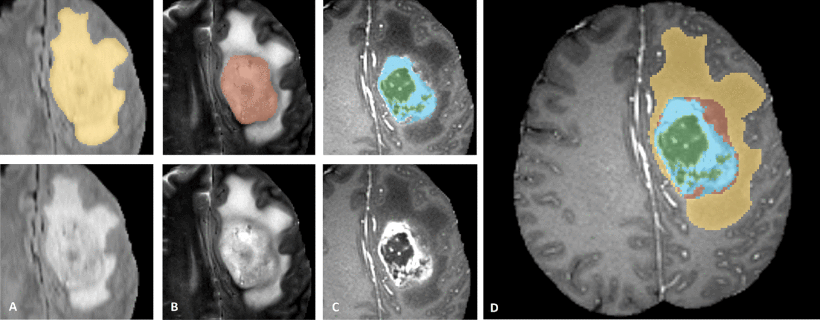

The image patches show from lefft to right :


1.   the whole tumor **yellow** visible in T2-Floair (fig A)
2.  the tumor core **red** visible in T2 (fig B)
3.  the enhancing tumor structures **Cyan** visible in T1Gd, surrounding the cystic/necrotic components of the core **green**
4.  The segmentations are combined to generate the final labels of the tumor sub-region (Fig D) :
*   edema(yellow)
*   non-enhancing solid core (red)
*   necrotic/cystic core (green)
*   enhancing core (blue)







#

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.6 MB/s eta 0:00:0000:010:01
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'onnxruntime'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 82.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00


Setup imports

In [ ]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()

MONAI version: 1.5.dev2450
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 0726cee7ba6c1b31f34d54fc26fe6b8db5f5c79c
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

### Setup data directory

In [ ]:
directory = os.environ.get("Monai_data_directory")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp71owkk53


Set derterministic trining for reproducibility

In [ ]:
set_determinism(seed=0)

## Define

### Define a new transform to convert brain tumor labels
Here we convert the multiclasses labels into multi-labels segmentation task in On-hot format.

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and  ET (Enhancing tumor).
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            results = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3 ),d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

SetupTransforms for taraining

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

Setup transforms for the validation

In [ ]:
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]

)


## loading data with DecathlonDataset
Here we use DecathlonDataset to automatically download and extract the dataset. It inherits MONAI CacheDataset

In [ ]:
# here we don't cache any data in case of memory issue

train_ds = DecathlonDataset(
    root_dir = root_dir,
    task = "Task01_BrainTumour",
    transform = train_transform,
    section = "training",
    download = True,
    cache_rate = 0.0,
    num_workers = 4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers =4)

Task01_BrainTumour.tar: 7.09GB [03:04, 41.3MB/s]                               

2024-12-21 10:22:51,276 - INFO - Downloaded: /tmp/tmp71owkk53/Task01_BrainTumour.tar


2024-12-21 10:23:04,538 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-12-21 10:23:04,539 - INFO - Writing into directory: /tmp/tmp71owkk53.


In [ ]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)


**Check data shape and visualize**

In [ ]:
 #pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()


RuntimeError: applying transform <__main__.ConvertToMultiChannelBasedOnBratsClassesd object at 0x7b1de0449510>

### Create Model, Loss, Optimizer

In [ ]:
max_epochs = 3
val_interval = 1
VAL_AMP =True

#standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down = [1, 2, 2, 4],
    blocks_up = [1, 1, 1],
    init_filters = 16,
    in_channels = 4,
    out_channels = 3,
    dropout_prob = 0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return silding_window_inference(
            inputs=input,
            roi_size=(240,240,160),
            sw_batch_size=1,
            predictor = model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return  _compute(input)
    else:
        return _compute(input)

# use amp to accelearte training
scler = torch.amp.GradScaler("cuda")
# enablle cuDNN benchmark
torch.backends.cudnn.benchmark = True




